In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize' ]= 16,9

from thompson_sampling.models import BatchBayesLinReg
from thompson_sampling.solvers import GaussianContextualSampler, GaussianUniversalContextualSampler,GaussianContextualSamplerSingleModel


Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
num_data = 1000

data_max = .5
data_min = -.5

np.random.seed(42)

x1 = np.linspace(data_min,data_max,num=num_data) 
x2 = np.random.choice([0,1,],p=[0.6,0.4],size=num_data)

y = x1.copy() 

x1[x2 == 0] =  np.random.uniform(-.5,data_max,num_data - sum(x2))

x3 = y + np.random.normal(0,data_max/5,num_data)

In [ ]:
#x1

In [ ]:
np.sum(x2 == 1)

387

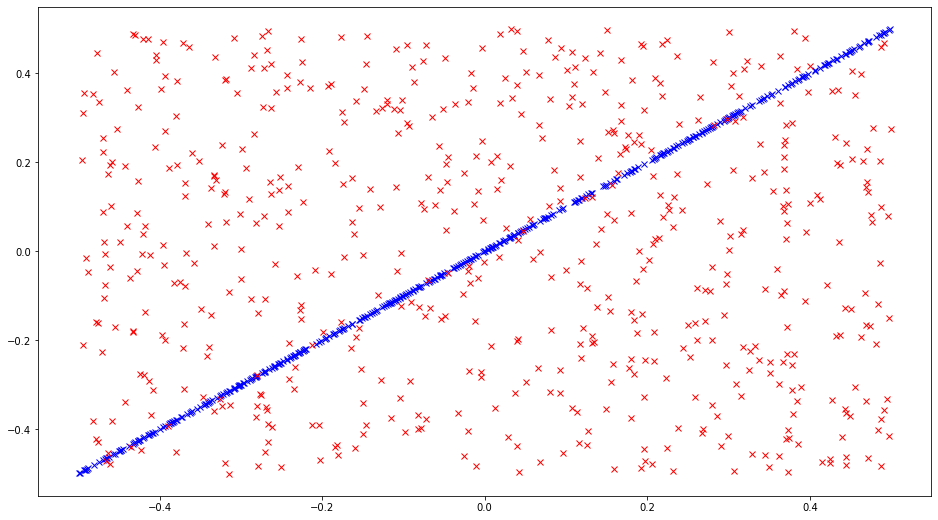

In [ ]:
plt.plot(x1[x2==1],y[x2==1],'x',color='blue')
plt.plot(x1[x2==0],y[x2==0],'x',color='red')

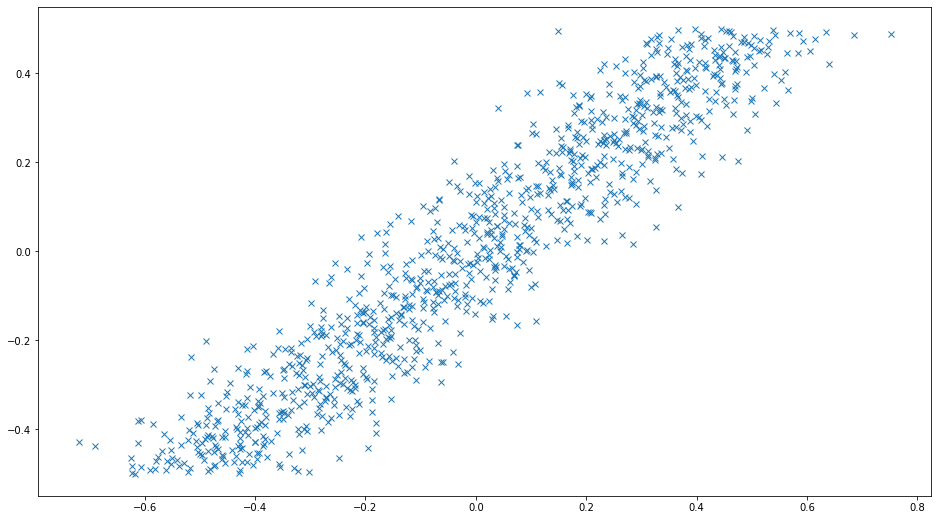

In [ ]:
plt.plot(x3,y,'x')

In [ ]:
yhat = x1*x2 + x3*(1-x2)

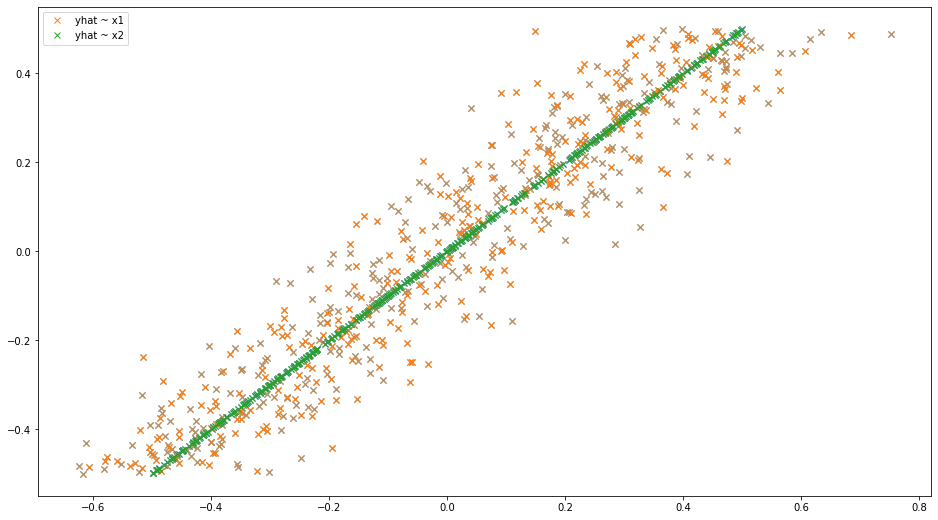

In [ ]:
plt.plot(yhat,y,'x')
plt.plot(x3[x2==0],y[x2==0],'x',label='yhat ~ x1')
plt.plot(x1[x2==1],y[x2==1], 'x',label='yhat ~ x2')
plt.legend()

In [ ]:
model1 = BatchBayesLinReg(n_features = 3,alpha=1,beta=1)


In [ ]:
model1 = BatchBayesLinReg(n_features = 3,alpha=10,beta=10)
model1.cov_inv

# http://krasserm.github.io/2019/02/23/bayesian-linear-regression/

array([[0.1, 0. , 0. ],
       [0. , 0.1, 0. ],
       [0. , 0. , 0.1]])

In [ ]:
X = np.array([x1,x2,x3])
X.shape, y.shape

((3, 1000), (1000,))

In [ ]:

for x_batch, y_batch in zip(X.T,np.atleast_2d(y).T):
    
    model1.observe(x_batch,y_batch)
    

In [ ]:
x_batch

array([0.03295779, 0.        , 0.39737804])

In [ ]:
y_batch

array([0.5])

In [ ]:
y_hat_dist = model1.predict(X.T)

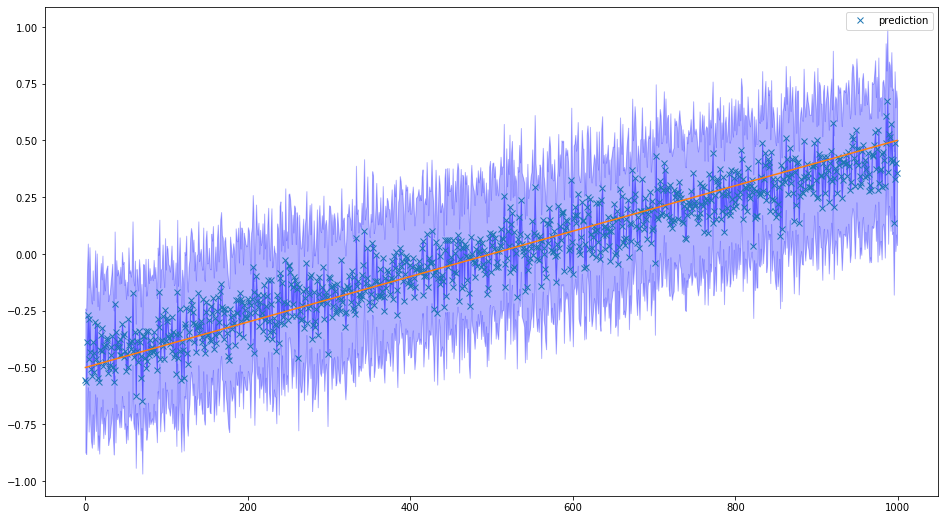

In [ ]:
y_hat = y_hat_dist.mean()
y_hat_std = y_hat_dist.std()


plt.fill_between(np.arange(num_data), y_hat, y_hat - y_hat_std, alpha = 0.3,color='blue')
plt.fill_between(np.arange(num_data), y_hat, y_hat + y_hat_std, alpha = 0.3,color='blue')


yhat_model = model1.weights_dist.mean @ X
plt.plot(yhat_model,'x',label='prediction')
plt.plot(y)
plt.legend()

In [ ]:
model1.weights_dist.mean

array([ 9.81057842e-03, -6.02808867e-04,  8.97267159e-01])

In [ ]:
np.mean((y-yhat_model)**2)

0.008847847611506638

# w ts

In [ ]:
universal=False
beta = 1
alpha = 10

In [ ]:
model2 = BatchBayesLinReg(n_features = 3,alpha=1,beta=10)

In [ ]:

gcs1 = GaussianContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
gcs2 = GaussianContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
gcs3 = GaussianContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})


if universal:

    gcs1 = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
    gcs2 = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})
    gcs3 = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 3+1,model_params={'alpha':alpha, 'beta':beta})

In [ ]:
def make_attention(X):
    attention1 = gcs1.choose_arm(X)
    attention2 = gcs2.choose_arm(X)
    attention3 = gcs3.choose_arm(X)
    
    
    
    attention = np.array([attention1, attention2, attention3])
    return attention

def make_input(X):
    attention = make_attention(X)
    
    input_vec = x_batch * attention
    return input_vec

In [ ]:
def predict_with_mix(X):
    input_vec = make_input(add_intercept(X))
    pred_dist = model2.predict(X)
    return pred_dist
    
    
def add_intercept(X):
    X = np.append(X,1)
    return X

In [ ]:
from sklearn.model_selection import train_test_split

num_epochs = 1

In [ ]:
# for j in range(num_epochs):
#     X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.01, random_state=42)
#     for i,(x_batch, y_batch) in enumerate(zip(X.T,np.atleast_2d(y).T)):
#         #context = np.concatenate(x_batch)

#         x_batch_attention = add_intercept(x_batch)
#         attention = make_attention(x_batch_attention)

#         input_vec = x_batch * attention

#         if i % (num_data/20) == 0:
#             plt.figure()
#             #gcs1.choose_arm_and_plot(x_batch)
#             gcs2.choose_arm_and_plot(x_batch_attention)
#             #gcs3.choose_arm_and_plot(x_batch)


#         error = model2.observe(input_vec,y_batch)

#         gcs1.update(attention[0], x_batch_attention, error)
#         gcs2.update(attention[1], x_batch_attention, error)
#         gcs2.update(attention[2], x_batch_attention, error)
    

In [ ]:
x_batch

array([0.03295779, 0.        , 0.39737804])

In [ ]:
model2.weights_dist.mean

array([0., 0., 0.])

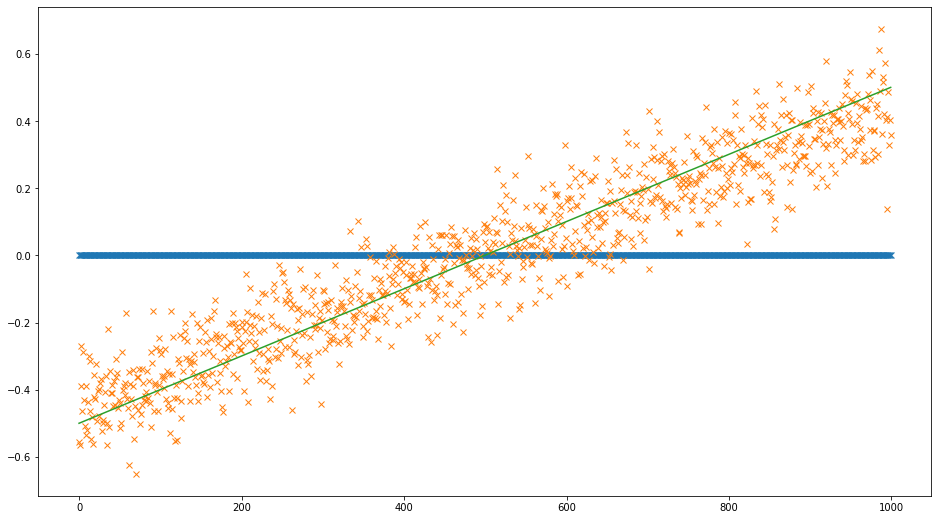

In [ ]:
y_hat = []
y_hat_std = []
for x in X.T:
    y_hat += [predict_with_mix(x).mean()]
    y_hat_std += [predict_with_mix(x).std()]
    
    
    
plt.plot(y_hat,'x')
plt.plot(yhat_model,'x')
plt.plot(y)


In [ ]:
a = [make_attention(add_intercept(X.T[0])) for x in range(100)]
np.mean(a,0)

array([0.62, 0.51, 0.55])

In [ ]:
a = [make_attention(add_intercept(X.T[1])) for x in range(100)]
np.mean(a,0)

array([0.48, 0.52, 0.47])

In [ ]:
add_intercept(X.T[0])

array([-0.31486707,  0.        , -0.61726033,  1.        ])

In [ ]:
add_intercept(X.T[1])

array([-0.498999  ,  1.        , -0.62234581,  1.        ])

In [ ]:
X.T[1]

array([-0.498999  ,  1.        , -0.62234581])

In [ ]:
do_add_intercept = False


In [ ]:
# TODO: Sample from different Arms you honk

In [ ]:


def make_attention(X):
    return gcssm.choose_arm(np.array(X))

def add_intercept(X):
    if do_add_intercept:
        X = np.append(X,np.atleast_1d(1))
    return X

In [ ]:
model3 = BatchBayesLinReg(n_features = 3+do_add_intercept,alpha=1,beta=10)
gcssm = GaussianContextualSamplerSingleModel(BatchBayesLinReg,num_arms=3, num_context = 3+do_add_intercept,model_params={'alpha':1, 'beta':4})

a = [make_attention(add_intercept(X.T[1]))['arm'] for x in range(1000)]
np.mean(a,0)

array([0.596, 0.625, 0.598])

In [ ]:
def predict_with_mix(X):
    #input_vec = make_input(add_intercept(X))
    pred_dist = model3.predict(X)
    return pred_dist

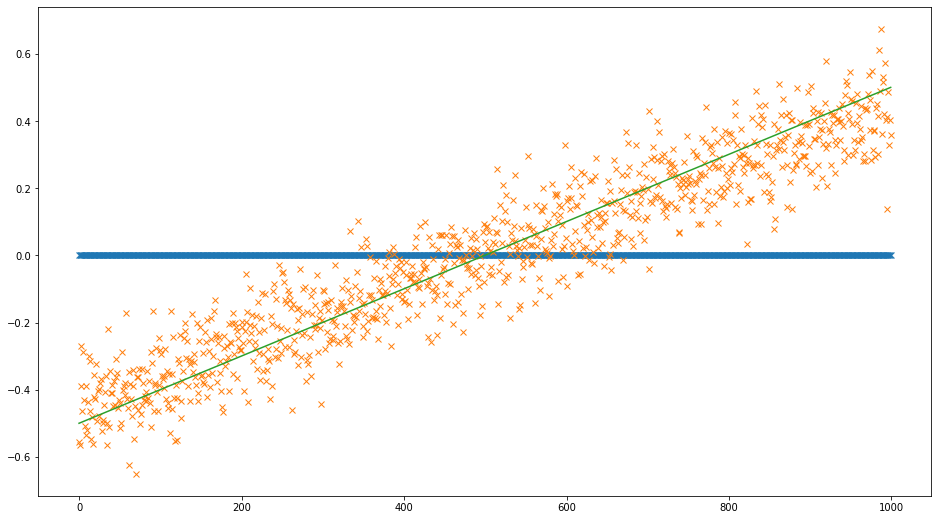

In [ ]:
y_hat = []
y_hat_std = []
for x in X.T:
    y_hat += [predict_with_mix(add_intercept(x)).mean()]
    y_hat_std += [predict_with_mix(add_intercept(x)).std()]
    
    
    
plt.plot(y_hat,'x')
plt.plot(yhat_model,'x')
plt.plot(y)


In [ ]:
meta_errors = []
for j in range(3):
    errors = []
    X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.001, random_state=42,shuffle=True)
    for i,(x_batch, y_batch) in enumerate(zip(X_train ,np.atleast_2d(y_train).T)):
        #context = np.concatenate(x_batch)
        #print(x_batch.shape)
        #print(y_batch.shape)

        x_batch_attention = add_intercept(x_batch)
        attention = make_attention(x_batch_attention)

        input_vec = x_batch_attention * add_intercept(attention['arm'])

#         if i % (num_data/20) == 0:
#             plt.figure()
#             #gcs1.choose_arm_and_plot(x_batch)
#             gcs2.choose_arm_and_plot(x_batch_attention)
#             #gcs3.choose_arm_and_plot(x_batch)


        error = model3.observe(input_vec,y_batch)
        errors.append(error)

        gcssm.update(attention['arm_ix'], x_batch_attention, error)
    meta_errors.append(np.mean(error))

    

In [ ]:
X_train.shape, y_train.shape

((999, 3), (999,))

In [ ]:
meta_errors

[0.0012870972933982062, 0.0013613365218071852, 0.14809516948454102]

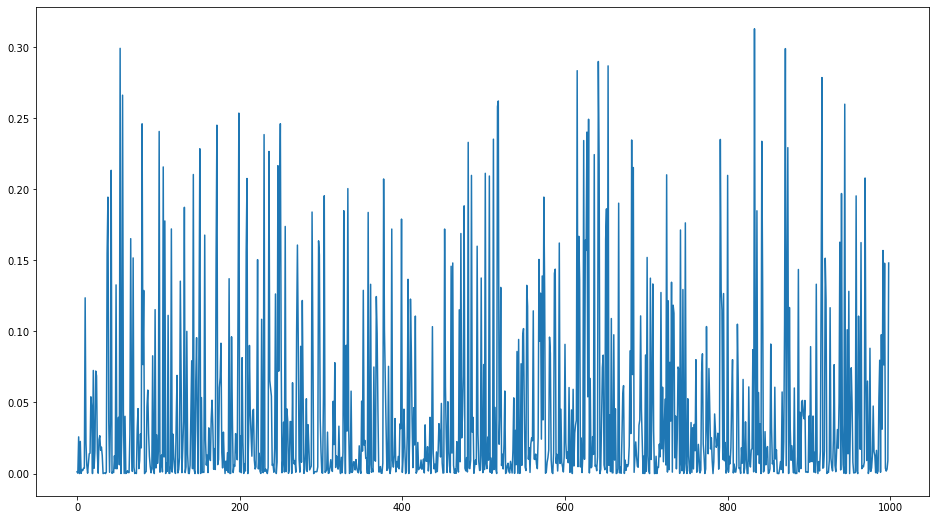

In [ ]:
plt.plot(errors)

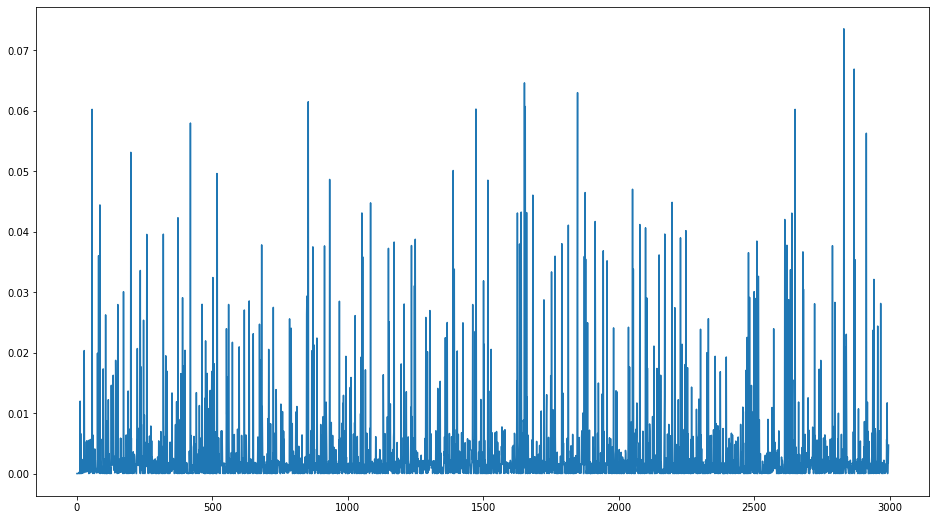

In [ ]:
plt.plot(gcssm.errors)

In [ ]:
x_batch * attention['arm'], attention['arm'] 

(array([-0.078643,  0.      , -0.      ]), array([1., 1., 0.]))

In [ ]:
x_batch

array([-0.078643  ,  0.        , -0.40088695])

In [ ]:
attention['arm_ix']

2

In [ ]:
a = [make_attention(add_intercept(X.T[1]))['arm'] for x in range(1000)]
np.mean(a,0)

array([0.585, 0.616, 0.536])

In [ ]:
def predict_with_mix(X):
    #input_vec = make_input(add_intercept(X))
    pred_dist = model3.predict(X)
    return pred_dist

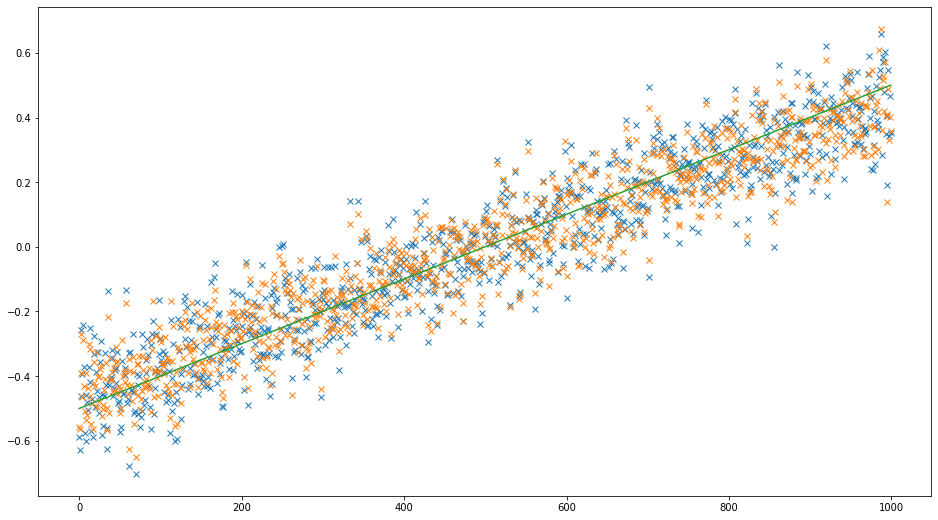

In [ ]:
y_hat = []
y_hat_std = []
for x in X.T:
    y_hat += [predict_with_mix(add_intercept(x)).mean()]
    y_hat_std += [predict_with_mix(add_intercept(x)).std()]
    
    
    
plt.plot(y_hat,'x')
plt.plot(yhat_model,'x')
plt.plot(y)


In [ ]:
gcssm.model.weights_dist.mean, gcssm.model.weights_dist.cov

(array([ 0.04122448,  0.03918216, -0.03574809,  0.00217155,  0.00342782,
         0.00182201]),
 array([[ 2.25696585e-04, -6.89237207e-05, -6.20726513e-05,
         -1.71158558e-05, -6.28649957e-05,  5.97507297e-06],
        [-6.89237207e-05,  2.31052819e-04, -6.50654321e-05,
          9.25228438e-06, -6.08107463e-05, -1.53767574e-05],
        [-6.20726513e-05, -6.50654321e-05,  2.48770606e-04,
         -1.57235609e-05, -6.07813844e-05,  9.86112307e-06],
        [-1.71158558e-05,  9.25228438e-06, -1.57235609e-05,
          1.12909651e-03,  2.74880327e-05, -3.63820457e-04],
        [-6.28649957e-05, -6.08107463e-05, -6.07813844e-05,
          2.74880327e-05,  3.24983066e-04,  1.37381570e-05],
        [ 5.97507297e-06, -1.53767574e-05,  9.86112307e-06,
         -3.63820457e-04,  1.37381570e-05,  1.02411565e-03]]))

In [ ]:
gcssm.arms

OrderedDict([(0, array([0., 1., 1.])),
             (1, array([1., 0., 1.])),
             (2, array([1., 1., 0.])),
             (3, array([1., 0., 0.])),
             (4, array([0., 1., 0.])),
             (5, array([0., 0., 1.])),
             (6, array([1., 1., 1.]))])